In [84]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import GridSearchCV


print(tf.__version__)


1.14.0


In [85]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
Y = 'PH'
Y_name = 'Plant Height'

In [87]:
Y = 'FE'
Y_name = 'Fruit efficiency'

In [141]:
Y = 'TKW'
Y_name = 'Thousand kernel weight'

In [142]:
Y = 'HD'
Y_name = 'Heading date'

In [143]:
Y = 'KNS'
Y_name = 'Kernel number per spike'

In [88]:
df = pd.read_csv('data/prepared.csv', sep='\t')
Y

'FE'

In [89]:

phenotypes_discard = ['HD','PH','FE','TKW','KNS']
phenotypes_discard.remove(Y)
#phenotypes_discard.remove('HD')

In [90]:
phenotypes_discard

['HD', 'PH', 'TKW', 'KNS']

In [91]:

df = pd.read_csv('data/prepared.csv', sep='\t')

In [92]:
df.head(4)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,KNS,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016,Taxa
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,55 CL 2
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,26.75,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,55 CL 2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,22.70,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,55 CL 2
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,38.80,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,55 CL 2


In [93]:
#df.drop(columns={'2012','2013','2014','2015','2016'}, inplace=True)

In [94]:
len(df.index)

2040

In [95]:
df.drop(phenotypes_discard, axis=1, inplace=True)


In [96]:
df.head(2)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,FE,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016,Taxa
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,55 CL 2
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,58.79,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,55 CL 2


In [97]:
len(df[df['FE'].isna()].index)

209

In [98]:
df = df.dropna()

In [99]:
len(df.index)

1831

In [103]:
df.head(2)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,FE,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016,Taxa
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,58.79,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,55 CL 2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,53.73,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,55 CL 2


In [107]:
df.sort_values(Y, ascending=False).head(5)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,FE,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016,Taxa
178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,350.89,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ACA 906
378,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,281.25,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,BAGUETTE PREMIUM 11
298,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,245.86,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,BAGUETTE 21
1959,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,185.26,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,PROINTA ISLA VERDE
344,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,184.33,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,BAGUETTE 9


In [108]:
if Y == 'FE':
    df = df[df['FE'] < 200]
    df = df[df['FE'] > 20]
    len(df.index)

In [109]:
import random

In [110]:
#train_dataset = df.sample(frac=0.8,random_state=1)
#test_dataset = df.drop(train_dataset.index)


In [111]:
df.Taxa.nunique()

102

In [112]:
lineas = list(df['Taxa'].unique())
frac = 0.85 * float(len(lineas))
train_lines = random.sample(lineas,int(frac))

In [113]:
int(frac) - 102

-16

In [114]:
len(train_lines)

86

In [115]:
train_dataset = df[df.Taxa.isin(train_lines)]
test_dataset = df[~df.Taxa.isin(train_lines)]

In [116]:
len(df.index), len(train_dataset.index), len(test_dataset.index)

(1824, 1540, 284)

In [117]:
Y

'FE'

In [118]:
#if Y == 'FE':
#    test_lines = ['BAGUETTE PREMIUM 11','BAGUETTE 19','ACA 906','BIOINTA 1005','BIOINTA 1002','BUCK PRONTO','BUCK NAPOSTÁ']
#if Y == 'PH':
#    test_lines = ['OLAETA ARTILLERO','BUCK NAPOSTÁ','KLEIN ATLAS','SINVALOCHO MA','KLEIN CACIQUE','KLEIN DON ENRIQUE','PROINTA ISLA VERDE','SRM NOGAL','BAGUETTE 31','ACA 906']
#if Y == 'HD':
#    test_lines = ['BAGUETTE 31','BAGUETTE 30','LE 2271','BAGUETTE 21','ACA 223','KLEIN TIGRE','SY 300','AGP FAST','MARCOS JUÁREZ INTA','55 CL 2']
#if Y == 'TKW':
#    test_lines = ['OLAETA ARTILLERO','SY 200','KLEIN ZORRO','KLEIN ATLAS','KLEIN NUTRIA','CENTINELA','BARLETA 77','BAGUETTE 19','BAGUETTE 31','BAGUETTE 21']
#if Y == 'TKW':
#    test_lines = ['OLAETA ARTILLERO','SY 200','KLEIN ZORRO','KLEIN ATLAS','KLEIN NUTRIA','CENTINELA','BARLETA 77','BAGUETTE 19','BAGUETTE 31','BAGUETTE 21']
#if Y == 'KNS':
#    test_lines = ['BIOINTA 3004','PROINTA OASIS','CENTINELA','KLEIN PANTERA','KLEIN GUERRERO','BAGUETTE 31','KLEIN ATLAS','BUCK RANQUEL','BIOINTA 3003','KLEIN 32']
#train_dataset = df[~df.Taxa.isin(test_lines)]
#test_dataset = df[df.Taxa.isin(test_lines)]
#print(len(df.index), len(train_dataset.index), len(test_dataset.index))
#print(len(test_dataset.index)  * 100 / len(df.index))
#print(test_lines)

In [119]:
train_taxa = train_dataset.pop('Taxa')
test_taxa = test_dataset.pop('Taxa')

In [120]:
"""
train_stats = train_dataset.describe()
train_stats.pop(Y)
train_stats = train_stats.transpose()
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
#normed_train_data = norm(train_dataset)
#normed_test_data = norm(test_dataset)
"""


"\ntrain_stats = train_dataset.describe()\ntrain_stats.pop(Y)\ntrain_stats = train_stats.transpose()\ndef norm(x):\n    return (x - train_stats['mean']) / train_stats['std']\n#normed_train_data = norm(train_dataset)\n#normed_test_data = norm(test_dataset)\n"

In [121]:
def normalize(array): 
    return (array - array.mean()) / array.std()


In [122]:
train_labels = train_dataset.pop(Y)
test_labels = test_dataset.pop(Y)


In [138]:
len(train_labels), len(train_dataset.index)

(1540, 1540)

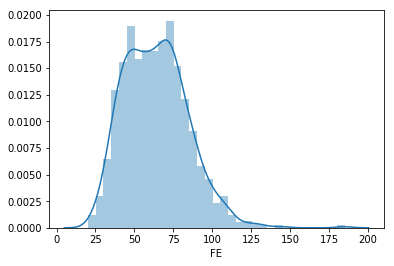

In [123]:
sns.distplot(train_labels)

In [124]:
normed_train_labels = normalize(train_labels)
normed_test_labels = normalize(test_labels)

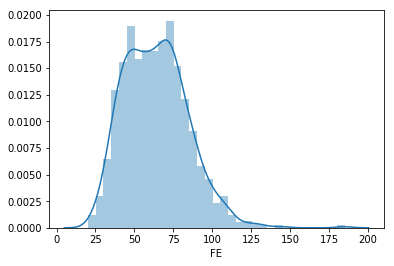

In [125]:
sns.distplot(train_labels)

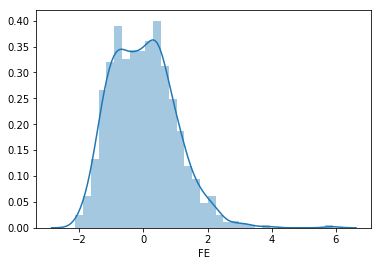

In [127]:
sns.distplot(normed_train_labels)

In [136]:
len(normed_train_labels), len(train_labels)

(1540, 1540)

In [156]:

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
      ])

    optimizer = tf.keras.optimizers.RMSprop(0.0001)

    #model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mean_absolute_error', 'mean_squared_error','mean_absolute_percentage_error'])
    model.compile(loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error','mean_absolute_percentage_error']
        )
    return model
#accuracy

In [157]:
"""
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential, load_model

def build_model():

    # Instantiate
    model = Sequential()

    # Add first layer
    model.add(Dense(64, input_dim=len(train_dataset.keys())))
    model.add(Activation('relu'))
    # Add second layer
    model.add(Dense(32))
    model.add(Activation('softplus'))
    # Last, output layer
    model.add(Dense(1))

    # Model Compiling (https://keras.io/models/sequential/) 
    # compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
    # Stochastic Gradient Descent (‘sgd’) as optimization algorithm
    # Mean Squared Error as loss, ie, quantitative variable, regression
    model.compile(loss='mean_squared_error', optimizer='sgd',metrics=['mean_absolute_error', 'mean_squared_error','mean_absolute_percentage_error'])
    return model
"""

"\nfrom keras.layers import Dense, Activation, Dropout\nfrom keras.models import Sequential, load_model\n\ndef build_model():\n\n    # Instantiate\n    model = Sequential()\n\n    # Add first layer\n    model.add(Dense(64, input_dim=len(train_dataset.keys())))\n    model.add(Activation('relu'))\n    # Add second layer\n    model.add(Dense(32))\n    model.add(Activation('softplus'))\n    # Last, output layer\n    model.add(Dense(1))\n\n    # Model Compiling (https://keras.io/models/sequential/) \n    # compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)\n    # Stochastic Gradient Descent (‘sgd’) as optimization algorithm\n    # Mean Squared Error as loss, ie, quantitative variable, regression\n    model.compile(loss='mean_squared_error', optimizer='sgd',metrics=['mean_absolute_error', 'mean_squared_error','mean_absolute_percentage_error'])\n    return model\n"

In [158]:
model = build_model()


In [159]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                321280    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 325,505
Trainable params: 325,505
Non-trainable params: 0
_________________________________________________________________


In [163]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result


array([[-0.03596883],
       [-0.03596883],
       [-0.01414411],
       [-0.01414411],
       [-0.02705793],
       [-0.02705793],
       [-0.06540643],
       [-0.06540643],
       [-0.0595582 ],
       [-0.0595582 ]], dtype=float32)

In [164]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

        
EPOCHS = 1000

history = model.fit(
    train_dataset, normed_train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[early_stop, PrintDot()])



...............................................

In [165]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,val_loss,val_mean_absolute_error,val_mean_squared_error,val_mean_absolute_percentage_error,epoch
42,0.665787,0.645783,0.665787,133.059448,0.835141,0.707705,0.835141,199.628784,42
43,0.661773,0.640325,0.661773,137.338058,0.822208,0.704098,0.822208,205.340668,43
44,0.661511,0.641498,0.661511,128.855804,0.821554,0.703960,0.821554,207.396301,44
45,0.659677,0.640400,0.659676,135.768494,0.830112,0.706025,0.830112,202.655258,45
46,0.657851,0.638563,0.657851,131.914047,0.826440,0.705600,0.826440,206.982742,46


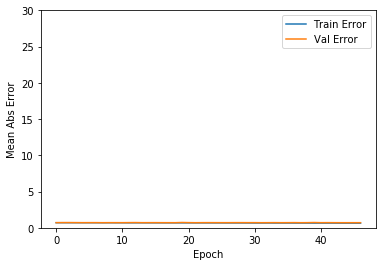

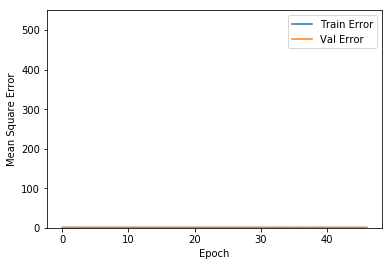

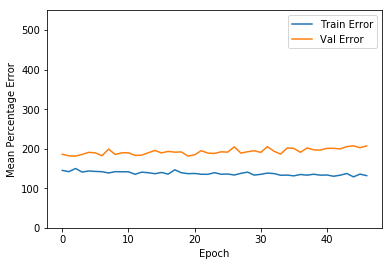

In [166]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0,550])
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Percentage Error')
    plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
    plt.ylim([0,550])
    plt.legend()
    plt.show()

    
    

plot_history(history)


In [155]:
loss, mae, mse, mape = model.evaluate(test_dataset, normed_test_labels, verbose=0)
loss, mae, mse, mape

(0.6056101120693583, 0.62134415, 0.60561013, 1455.168)

In [154]:
model.evaluate(test_dataset, normed_test_labels, verbose=0)

[0.6056101120693583, 0.62134415, 0.60561013, 1455.168]

In [144]:

def f_city(x):
    if x['Balcarce'] == 1.0: return 'Balcarce'
    if x['Azul'] == 1.0: return 'Azul'
    if x['MsJz'] == 1.0: return 'MsJz'

city = test_dataset.apply(f_city, axis=1)

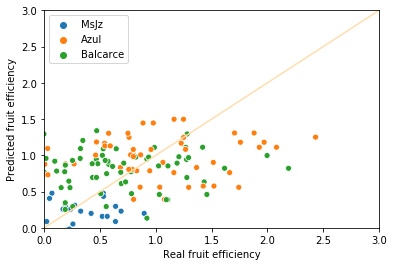

<Figure size 432x288 with 0 Axes>

In [152]:
test_predictions = model.predict(test_dataset).flatten()

sns.scatterplot(x=normed_test_labels,y=test_predictions,hue=city)
_ = plt.plot([0, 350], [0, 350], color='navajowhite')
plt.xlabel('Real ' + Y_name.lower())
plt.ylabel('Predicted ' + Y_name.lower())
plt.xlim(0, 3)
plt.ylim(0, 3)
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig('data/' + Y + '_predict_vs_real.png', dpi=150)


In [153]:
mse_prediction = model.evaluate(test_dataset, normed_test_labels)
mse_prediction

284/284 [==============================] - 0s 76us/sample - loss: 0.6056 - mean_absolute_error: 0.6213 - mean_squared_error: 0.6056 - mean_absolute_percentage_error: 1455.1680


[0.6056101120693583, 0.62134415, 0.60561013, 1455.168]

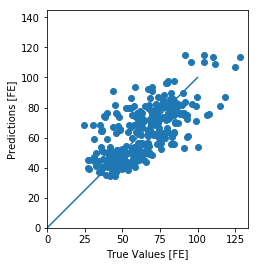

In [334]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [' + Y + ']')
plt.ylabel('Predictions [' + Y + ']')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


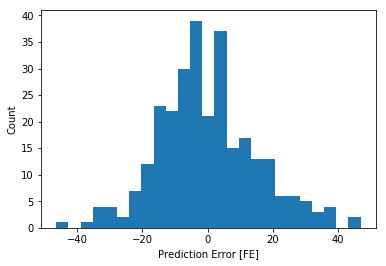

In [335]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [" + Y + "]")
_ = plt.ylabel("Count")


In [626]:
import numpy as np
import locale


In [627]:
diff = test_predictions.flatten() - test_labels
percentDiff = (diff / test_labels) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
 
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))


[INFO] mean: 30.69%, std: 99.22%


In [628]:
diff = test_predictions.flatten() - test_labels
percentDiff = (diff / test_labels) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
 
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))


[INFO] mean: 30.69%, std: 99.22%


In [629]:
test_city = test_dataset.apply(f_city, axis=1)
test_dataset['Taxa'] = test_taxa
test_dataset['Real'] = test_labels
test_dataset['Predicted'] = test_predictions
test_dataset['City'] = test_city


/home/juan/Desktop/juan/bio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/juan/Desktop/juan/bio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/juan/Desktop/juan/bio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [630]:

def f_year(x):
    if x['2012'] == 1.0: return '2012'
    if x['2013'] == 1.0: return '2013'
    if x['2014'] == 1.0: return '2014'
    if x['2015'] == 1.0: return '2015'
    if x['2016'] == 1.0: return '2016'

test_dataset['Year'] = test_dataset.apply(f_year, axis=1)

/home/juan/Desktop/juan/bio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [631]:
test_results = test_dataset[['Taxa','Real','Predicted','City','Year']]

In [632]:
test_results.Taxa.unique()

array(['BAGUETTE 31', 'BIOINTA 3003', 'BIOINTA 3004', 'BUCK RANQUEL',
       'CENTINELA', 'KLEIN 32', 'KLEIN ATLAS', 'KLEIN GUERRERO',
       'KLEIN PANTERA', 'PROINTA OASIS'], dtype=object)

In [633]:
test_lines

['BIOINTA 3004',
 'PROINTA OASIS',
 'CENTINELA',
 'KLEIN PANTERA',
 'KLEIN GUERRERO',
 'BAGUETTE 31',
 'KLEIN ATLAS',
 'BUCK RANQUEL',
 'BIOINTA 3003',
 'KLEIN 32']

In [634]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [635]:
plot_single = test_results[test_results['Taxa'].isin(test_lines)]
plot_single['What'] = plot_single['Taxa'] + '_' + plot_single['City'] + '_' +  plot_single['Year'] 
plot_single = plot_single[['What','Predicted','Real']]
df_plot = pd.melt(plot_single, id_vars="What", var_name="Value", value_name=Y)
#sns.factorplot(x='What', y=Y, hue='Value', data=df_plot, kind='bar',size=10, aspect=2)


In [636]:
res = test_results[test_results['Taxa'].isin(test_lines)]
res    

,Taxa,Real,Predicted,City,Year
321,BAGUETTE 31,11.20,33.560913,MsJz,2012
322,BAGUETTE 31,15.95,33.560913,MsJz,2012
323,BAGUETTE 31,30.50,37.021091,MsJz,2013
324,BAGUETTE 31,25.60,37.021091,MsJz,2013
325,BAGUETTE 31,24.70,34.853889,MsJz,2014
326,BAGUETTE 31,18.40,34.853889,MsJz,2014
327,BAGUETTE 31,26.30,34.773212,MsJz,2015
328,BAGUETTE 31,28.10,34.773212,MsJz,2015
333,BAGUETTE 31,37.00,39.977772,Azul,2014
334,BAGUETTE 31,33.00,39.977772,Azul,2014


In [637]:
res.to_csv('data/'+Y+'_taxa.csv', sep='\t', index=None)
'data/'+Y+'_taxa.csv'

'data/KNS_taxa.csv'

In [577]:
plot_single = test_results[test_results['Taxa'] == 'KLEIN RENDIDOR']
plot_single['What'] = plot_single['Taxa'] + '_' + plot_single['City'] + '_' +  plot_single['Year'] 
plot_single = plot_single[['What','Predicted','Real']]
df_plot = pd.melt(plot_single, id_vars="What", var_name="Value", value_name=Y)
plt.figure(figsize=(100, 20))
sns.factorplot(x='What', y=Y, hue='Value', data=df_plot, kind='bar',size=10, aspect=2)


/home/juan/Desktop/juan/bio/venv/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/juan/Desktop/juan/bio/venv/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


ValueError: min() arg is an empty sequence

<Figure size 7200x1440 with 0 Axes>

In [612]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10)
results = cross_val_score(model, normed_test_data, test_labels, cv=kfold, scoring="r2")
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

TypeError: Cannot clone object '<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f10fdec34a8>' (type <class 'tensorflow.python.keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

In [588]:
df_low = pd.read_csv('data/b_low.csv',sep='\t')
df_low = df_low.dropna()
b_low_labels = df_low.pop(Y)
b_low_n = norm(df_low)

In [589]:
b_low_predictions = model.predict(b_low_n).flatten()


In [590]:
loss, mae, mse, mape = model.evaluate(b_low_n, b_low_labels, verbose=0)
loss, mae, mse, mape

(95.59172058105469, 6.8595643, 95.59172, 5.663361)

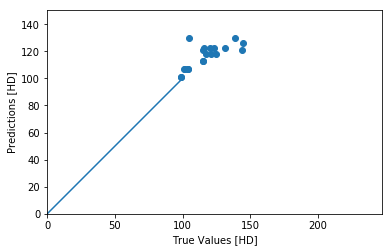

In [591]:

plt.scatter(b_low_labels, b_low_predictions)
plt.xlabel('True Values [' + Y + ']')
plt.ylabel('Predictions [' + Y + ']')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]+100])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [592]:
df_high = pd.read_csv('data/b_high.csv',sep='\t')
df_high = df_high.dropna()
b_high_labels = df_high.pop(Y)
b_high_n = norm(df_high)

In [593]:
b_high_predictions = model.predict(b_high_n).flatten()


In [594]:
loss, mae, mse, mape = model.evaluate(b_high_n, b_high_labels, verbose=0)
loss, mae, mse, mape

(31.510696411132812, 4.0391526, 31.510696, 3.9532182)

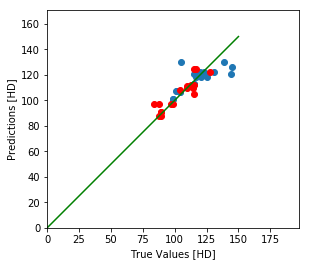

In [597]:

plt.scatter(b_low_labels, b_low_predictions)
plt.xlabel('True Values [' + Y + ']')
plt.ylabel('Predictions [' + Y + ']')
plt.axis('equal')
plt.axis('square')

plt.scatter(b_high_labels, b_high_predictions,color="red")
plt.xlim([0,plt.xlim()[1]+50])
plt.ylim([0,plt.ylim()[1]+20])



_ = plt.plot([-150, 150], [-150, 150], color="green")

In [603]:
df_plot = df_high[['Balcarce','Azul','MsJz']]
df_plot['real'] = b_high_labels
df_plot['predicted'] = b_high_predictions
df_plot['high'] = 1

df_plot_2 = df_low[['Balcarce','Azul','MsJz']]
df_plot_2['real'] = b_low_labels
df_plot_2['predicted'] = b_low_predictions
df_plot_2['high'] = 0

df_plot_ = pd.concat([df_plot, df_plot_2])

/home/juan/Desktop/juan/bio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/juan/Desktop/juan/bio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/juan/Desktop/juan/bio/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [606]:

def f_city(x):
    if x['Balcarce'] == 1.0: return 'Balcarce'
    if x['Azul'] == 1.0: return 'Azul'
    if x['MsJz'] == 1.0: return 'MsJz'

df_plot_['city'] = df_plot_.apply(f_city, axis=1)

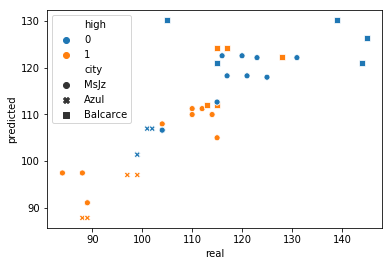

In [608]:
sns.scatterplot(data=df_plot_,x='real',y='predicted',hue='high',style='city')
plt.show()

In [437]:
df_15 = pd.read_csv('data/b15.csv',sep='\t')
df_15 = df_15.dropna()

In [438]:
b15_labels = df_15.pop(Y)


In [439]:
df_15.head(2)


,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,Chr7D-B17-Hap1,HD,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,108.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,104.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [440]:
df_15_n = norm(df_15)

In [441]:
b15_predictions = model.predict(df_15_n).flatten()


In [442]:
loss, mae, mse, mape = model.evaluate(df_15_n, b15_labels, verbose=0)
loss, mae, mse, mape

(2797.15625, 50.21666, 2797.1562, 64.19134)

In [443]:
b19_labels

1     71.25
2     69.74
3     70.22
5     49.12
6     66.16
7     51.59
8     40.79
9     47.92
11    86.95
12    76.99
13    47.23
14    61.39
15    70.33
16    73.91
17    75.78
18    77.76
19    90.52
Name: FE, dtype: float64

In [444]:
b15_labels

1      84.20
2      76.80
3      27.35
4      47.99
5      56.79
6      69.76
7      56.29
8      65.61
9      56.62
10     90.93
11     99.42
12    118.16
13     77.65
15     87.32
16     85.18
17     91.93
18    115.12
19     99.08
Name: FE, dtype: float64

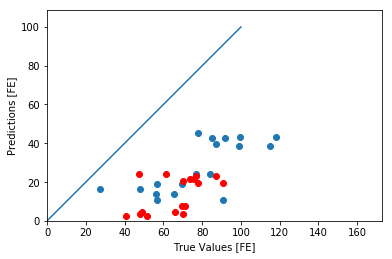

In [445]:

plt.scatter(b15_labels, b15_predictions)
plt.xlabel('True Values [' + Y + ']')
plt.ylabel('Predictions [' + Y + ']')
plt.axis('equal')
plt.axis('square')

plt.scatter(b19_labels, b19_predictions,color="red")
plt.xlim([0,plt.xlim()[1]+50])
plt.ylim([0,plt.ylim()[1]])



_ = plt.plot([-100, 100], [-100, 100])

In [50]:
test_dataset.head(2)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,Chr7D-B16-Hap2,Chr7D-B17-Hap1,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016
15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [51]:

def f_city(x):
    if x['Balcarce'] == 1.0: return 'Balcarce'
    if x['Azul'] == 1.0: return 'Azul'
    if x['MsJz'] == 1.0: return 'MsJz'

test_dataset['city'] = test_dataset.apply(f_city, axis=1)



In [52]:


def f_year(x):
    if x['2012'] == 1.0: return '2012'
    if x['2013'] == 1.0: return '2013'
    if x['2014'] == 1.0: return '2014'
    if x['2015'] == 1.0: return '2015'
    if x['2016'] == 1.0: return '2016'

test_dataset['year'] = test_dataset.apply(f_year, axis=1)

In [53]:
test_dataset.head(2)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016,city,year
15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Balcarce,2014
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,MsJz,2013


In [54]:
test_dataset.year.unique()

array(['2014', '2013', '2015', '2016', '2012'], dtype=object)

In [292]:
test_dataset.head(10)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,Chr7D-B16-Hap2,Chr7D-B17-Hap1,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016
15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [287]:
test_labels[:10]

15    105.0
20    123.0
21    102.0
24    114.0
25    110.0
43    116.0
44    123.0
55    145.0
63    122.0
77    125.0
Name: HD, dtype: float64

In [288]:
example_batch = normed_test_data
example_result = model.predict(example_batch)
example_result[:10]


array([[111.87069 ],
       [112.8963  ],
       [100.37991 ],
       [114.44746 ],
       [106.90659 ],
       [123.252464],
       [123.252464],
       [133.35104 ],
       [129.34128 ],
       [130.72043 ]], dtype=float32)

In [57]:
res = [x[0] for x in example_result]

In [ ]:
sns.scatterplot(x=test_labels,y=res,hue=test_dataset.city)
plt.show()

In [609]:
import eli5
from eli5.sklearn import PermutationImportance


Using TensorFlow backend.


In [ ]:
perm = PermutationImportance(model, random_state=1, scoring="r2").fit(normed_train_data,train_labels)


In [ ]:
eli5.show_weights(perm, feature_names = normed_train_data.columns.tolist())


In [ ]:
sns.scatterplot(x=test_labels,y=res,hue=test_dataset.year)
plt.show()

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
